In [2]:

import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/paper_printed_keyboard")
os.getcwd() 

'/content/drive/MyDrive/Colab Notebooks/paper_printed_keyboard'

In [3]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import cv2

#keras
import keras
from keras import layers
from keras import models
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, normalization
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
import sklearn.metrics as metrics
import sklearn
import cv2
from sklearn.pipeline import Pipeline

import os
import contextlib
import datetime

! apt-get install default-jre
!java -version
!pip install h2o
import h2o

Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.11-68ubuntu1~18.04.1).
default-jre set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
openjdk version "11.0.11" 2021-04-20
OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04)
OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)
     |████████████████████████████████| 164.8MB 18kB/s 
  Created wheel for h2o: filename=h2o-3.32.1.3-py2.py3-none-any.whl size=164854343 sha256=4507ed4da8f9456731b2e204a546b8bb7c691590dafbc75123a03aa25563a422
  Stored in directory: /root/.cache/pip/wheels/4f/bb/82/0988682f9abd0b5e95109a4aae6793dd427173b6dc671d9252
Successfully built h2o


# New Section

# New Section

In [ ]:
dir = "preprocessed"
batch_size = 64
train = keras.preprocessing.image_dataset_from_directory(
  dir,
  label_mode="categorical",
  color_mode="grayscale",
  validation_split=0.2,
  batch_size=batch_size,
  subset="training",
  image_size=(28, 56),seed=42)

val = keras.preprocessing.image_dataset_from_directory(
  dir,
  label_mode="categorical",
  color_mode="grayscale",
  validation_split=0.2,
  batch_size=batch_size,
  subset="validation",
  image_size=(28,56),seed=42)


Found 1229 files belonging to 10 classes.
Using 984 files for training.
Found 1229 files belonging to 10 classes.
Using 245 files for validation.


In [27]:
labeled_data = []
unlabeled_data = []
def load_images_from_folder(images,folder_name,num_class=None):
    for filename in os.listdir(folder_name):
        img = cv2.imread(os.path.join(folder_name,filename))
        if img is not None:
            flatten_img = img.flatten()
            normalized_img = flatten_img.astype("float32") / 255
            if num_class != None:
                img_with_class = np.append(np.array([num_class]),normalized_img)
                images.append(img_with_class)
            else:
                images.append(normalized_img)

for i in range(10):
    load_images_from_folder(labeled_data,f"datapreprocessed_2/{i}_preprocessed",i)

#load_images_from_folder(labeled_data,"dataset_preprocessed/Nan_preprocessed",11)
#load_images_from_folder(unlabeled_data,"dataset_preprocessed/unlabeled_preprocessed",np.nan)

In [28]:
labeled_data = np.array(labeled_data)
#unlabeled_data =np.array(unlabeled_data)
#columns_unlabeled =  [f"F_{i}" for i in range(unlabeled_data.shape[1])]
columns_labeled = ["labels"] + [f"F_{i}" for i in range(labeled_data.shape[1]-1)]
df_labeled = pd.DataFrame(data=labeled_data, columns=columns_labeled)
#df_unlabeled = pd.DataFrame(data=unlabeled_data, columns=columns_unlabeled)

df_labeled.to_csv("datapreprocessed_2/labeled_data.csv")
#df_unlabeled.to_csv("unlabeled.csv")

In [32]:
#unlabeled_data = pd.read_csv("unlabeled2.csv")
labeled_data = pd.read_csv("datapreprocessed_2/labeled_data.csv")
#labeled_data["labels"].replace({11:10})
labeled_data.to_csv("datapreprocessed_2/labeled_data2.csv",index=False)
#for i in range(10):
#    labeled_data["labels"] = labeled_data["labels"].replace({i:1})
#labeled_data["labels"] = labeled_data["labels"].replace({11:0})
#labeled_data.to_csv("labeled_data3.csv",index=False)



In [4]:
labeled_data = pd.read_csv("datapreprocessed_2/labeled_data2.csv",index_col=0)

labeled_data.head()

,labels,F_0,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,F_9,F_10,F_11,F_12,F_13,F_14,F_15,F_16,F_17,F_18,F_19,F_20,F_21,F_22,F_23,F_24,F_25,F_26,F_27,F_28,F_29,F_30,F_31,F_32,F_33,F_34,F_35,F_36,F_37,F_38,...,F_12248,F_12249,F_12250,F_12251,F_12252,F_12253,F_12254,F_12255,F_12256,F_12257,F_12258,F_12259,F_12260,F_12261,F_12262,F_12263,F_12264,F_12265,F_12266,F_12267,F_12268,F_12269,F_12270,F_12271,F_12272,F_12273,F_12274,F_12275,F_12276,F_12277,F_12278,F_12279,F_12280,F_12281,F_12282,F_12283,F_12284,F_12285,F_12286,F_12287
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
def get_val_train_data(train_data):
    X = train_data.drop("labels",axis=1).to_numpy()
    y = train_data["labels"].to_numpy()
    X_images = X.reshape((-1, 64, 64, 3))
    X_labels = to_categorical(y,num_classes=10)
    train_images,val_images, train_labels, val_labels = train_test_split(X_images,X_labels,
                                          test_size=0.20,random_state=42)
    return (train_images,val_images, train_labels, val_labels)

In [ ]:

def split_unlabeled_dataset(unlabeled_data_ar,predictions,threshold):
    cond = np.any(predictions > threshold,axis=1)

    new_train_set = unlabeled_data_ar[cond]


    labels = np.argmax(predictions[cond],axis=1)
    columns = [f"F_{i}" for i in range(new_train_set.shape[1])]
    new_df = pd.DataFrame(data=new_train_set,columns=columns)
    new_df["labels"] = labels
    new_df = new_df[["labels"] + columns]

    unlabeled_data_array = unlabeled_data_ar[np.invert(cond)]
    remain_unlabeled = pd.DataFrame(unlabeled_data_array,
                                  columns=unlabeled_data.columns)
    return (new_df,remain_unlabeled)

def predict_on_unlabeled_dataset(model,threshold,unlabeled):
    unlabeled_data_ar = unlabeled.to_numpy()
    predictions = model.predict(unlabeled_data_ar.reshape((-1,28,56,3)))
    return split_unlabeled_dataset(unlabeled_data_ar,predictions,threshold)

def get_new_train_set(train_set,unlabeled):
    model = models.load_model('/best_cnn')
    df,remain_unlabeled = predict_on_unlabeled_dataset(model=model,threshold=0.99,unlabeled=unlabeled)
    new_train_set = pd.concat([train_set,df])
    return (model,new_train_set,remain_unlabeled)



In [19]:
model = Sequential()
model.add(Conv2D(filters=64, kernel_size = (5,5), activation="relu", input_shape=(64,64,3)))
model.add(MaxPooling2D(pool_size=(3,3)))
#model.add(keras.layers.Dropout(0.5))
#model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
#model.add(MaxPooling2D(pool_size=(2,2)))
    
model.add(Flatten())
model.add(keras.layers.BatchNormalization())
model.add(Dense(32,activation="relu"))
#model.add(keras.layers.Dropout(0.5))

model.add(Dense(10,activation="softmax"))
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 60, 60, 64)        4864      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 25600)             0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 25600)             102400    
_________________________________________________________________
dense_8 (Dense)              (None, 32)                819232    
_________________________________________________________________
dense_9 (Dense)              (None, 10)                330       
Total params: 926,826
Trainable params: 875,626
Non-trainable params: 51,200
___________________________________________

In [20]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = keras.callbacks.TensorBoard(logdir, histogram_freq=1, profile_batch = '500,520')


In [9]:
lr_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                 patience=5, 
                                 verbose=2, 
                                 factor=.75)
model_checkpoint= keras.callbacks.ModelCheckpoint("/best_cnn", save_best_only=True,monitor='val_loss', verbose=1)

In [18]:
print(labeled_data.shape)
train_images,val_images, train_labels, val_labels = get_val_train_data(labeled_data)

model.fit(train_images,train_labels, epochs=100, batch_size=64,
              validation_data=(val_images,val_labels),
              callbacks=[ model_checkpoint])
    


(1044, 12289)
Epoch 1/100
14/14 [==============================] - 2s 77ms/step - loss: 1.7814 - accuracy: 0.3623 - val_loss: 2.1530 - val_accuracy: 0.2632

Epoch 00001: val_loss did not improve from 1.12804
Epoch 2/100
14/14 [==============================] - 1s 50ms/step - loss: 1.0444 - accuracy: 0.5996 - val_loss: 2.0267 - val_accuracy: 0.4067

Epoch 00002: val_loss did not improve from 1.12804
Epoch 3/100
14/14 [==============================] - 1s 48ms/step - loss: 0.8854 - accuracy: 0.6964 - val_loss: 1.9791 - val_accuracy: 0.5215

Epoch 00003: val_loss did not improve from 1.12804
Epoch 4/100
14/14 [==============================] - 1s 47ms/step - loss: 0.8551 - accuracy: 0.6822 - val_loss: 1.9163 - val_accuracy: 0.4689

Epoch 00004: val_loss did not improve from 1.12804
Epoch 5/100
14/14 [==============================] - 1s 45ms/step - loss: 0.8835 - accuracy: 0.6752 - val_loss: 1.9164 - val_accuracy: 0.4306

Epoch 00005: val_loss did not improve from 1.12804
Epoch 6/100
14/1

In [22]:
!cp  -r "/best_cnn" "/content/drive/MyDrive/Colab Notebooks/paper_printed_keyboard/bcnn"


<bound method Series.unique of 0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1040    9.0
1041    9.0
1042    9.0
1043    9.0
1044    9.0
Name: labels, Length: 1045, dtype: float64>

In [ ]:
values, counts = np.unique(L, return_counts=True)
print(values)
print(counts)

[ 3  6 10]
[  1   2 503]


In [ ]:
model = models.load_model('cnn.h5')
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_normalization_1_input  [(None, 28, 56, 1)]       0         
_________________________________________________________________
layer_normalization_1 (Layer (None, 28, 56, 1)         2         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 50, 32)        1600      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 25, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 21, 64)         51264     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 10, 64)         0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 3, 10, 64)         256   

In [ ]:
|h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.9.1" 2020-11-04; OpenJDK Runtime Environment (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpnijvebzv
  JVM stdout: /tmp/tmpnijvebzv/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpnijvebzv/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.4
H2O_cluster_version_age:,"7 days, 23 hours and 43 minutes"
H2O_cluster_name:,H2O_from_python_unknownUser_pp8zh6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8.84 Gb
H2O_cluster_total_cores:,40
H2O_cluster_allowed_cores:,40
H2O_cluster_status:,"accepting new members, healthy"


In [ ]:
def predict_on_unlabeled_dataset(model,threshold,unlabeled):
    predictions = model.predict(unlabeled)
    unlabeled_data_ar = h2o.as_list(unlabeled).to_numpy()
    predictions_as_np = h2o.as_list(predictions).to_numpy()
    df, remain_unlabeled = split_unlabeled_dataset(unlabeled_data_ar,predictions_as_np,threshold)
    return df,remain_unlabeled

In [ ]:
unlabeled_data = pd.read_csv("unlabeled2.csv")
labeled_data = pd.read_csv("labeled_data1.csv")
for i in range(10):
    labeled_data["labels"] = labeled_data["labels"].replace({i:1})
labeled_data["labels"] = labeled_data["labels"].replace({11:0})
df = labeled_data.loc[labeled_data['labels'] == 1]
df = df.sample(200)
labeled_data = pd.concat([df,labeled_data.loc[labeled_data['labels'] == 0]])
labeled_data.to_csv("labeled_data4.csv",index=False)

In [ ]:
df4 = pd.read_csv("labeled_data4.csv")
len(df4)

401

In [ ]:
gbm = h2o.estimators.H2OGradientBoostingEstimator()
pipe = Pipeline([
                ("pca", estimators.H2OPrincipalComponentAnalysisEstimator(k=2).init_for_pipeline()),
                ("rf", estimators.H2ORandomForestEstimator())])

while True:
    h2o_labeled = h2o.H2OFrame(labeled_data)
    h2o_labeled["labels"] = h2o_labeled["labels"].asfactor()
    predictors = h2o_labeled.columns
    response = "labels"  
    predictors.remove(response)

    #gbm.train(x=columns[1:], y=columns[0], training_frame=h2o_labeled)
    pipe.fit(h2o_labeled[1:],h2o_labeled[0])
    break
   # if remain_unlabeled.empty:
   #     break

   # new_labeled,remain_unlabeled = predict_on_unlabeled_dataset(model=gbm,threshold=0.99,unlabeled=h2o.H2OFrame(remain_unlabeled))
   # pd_labeled_data = pd.concat([pd_labeled_data,new_labeled])
   # print(f"Remaining unlabeled samples {len(remain_unlabeled)}")    

    


NameError: ignored

In [ ]:
path = os.getcwd()
#model_path = h2o.save_model(model=pipe["rf"],path=path, force=True)
#model_path = h2o.save_model(model=pipe["pca"],path=path, force=True)
!ls

best					h2o.zip
best2					labeled_data1.csv
best3					labeled_data.csv
best4					logs
best5					my_model.h5
best_cnn				PaperPrintedKeyboard.ipynb
best_result				PCA_model_python_1612876072783_110
cnn4.h5					PCA_model_python_1612876072783_110.zip
cnn5.h5					PCA_model_python_1612876072783_172
cnn.h5					pca.zip
dataset_preprocessed			pipeline
DRF_model_python_1612876072783_111	preprocessed
DRF_model_python_1612876072783_111.zip	unlabeled1.csv
DRF_model_python_1612876072783_173	unlabeled2.csv
features_1024.csv			unlabeled.csv
features_128.csv			unlabeled_data1.csv
features.csv				weights.h5


In [ ]:
X = labeled_data.drop("labels",axis=1)

y =  labeled_data["labels"]
pca = h2o.estimators.H2OPrincipalComponentAnalysisEstimator(k = 2)
pca.train(training_frame = h2o.H2OFrame(X))

Parse progress: |█████████████████████████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/h2o/estimators/estimator_base.py:200: RuntimeWarning: Dropping bad and constant columns: [F_1008, F_4519, F_1009, F_2339, F_4517, F_4518, F_1492, F_1491, F_1494, F_2341, F_3672, F_1010, F_1493, F_2340, F_1490, F_1015, F_2347, F_3678, F_4526, F_1016, F_1499, F_2346, F_3677, F_4527, F_2349, F_4524, F_2348, F_3679, F_4525, F_1496, F_2343, F_3674, F_4522, F_1495, F_2342, F_3673, F_4523, F_1498, F_2345, F_3676, F_4520, F_1014, F_1497, F_2344, F_3675, F_4521, F_4528, F_4529, F_2350, F_3681, F_3680, F_4530, F_3683, F_2351, F_3682, F_3205, F_3689, F_4537, F_3204, F_3688, F_4538, F_3207, F_4535, F_3206, F_4536, F_3201, F_3685, F_4533, F_1023, F_3200, F_3684, F_4534, F_1024, F_3203, F_3687, F_4531, F_1025, F_3202, F_3686, F_4532, F_2329, F_2328, F_2330, F_1004, F_1489, F_2336, F_4515, F_1005, F_1488, F_2335, F_4516, F_1006, F_2338, F_4513, F_1007, F_2337, F_4514, F_1000, F_2332, F_1001, F_2331, F_4512, F_1002, F_2334, F_1003, F_2333, F_3869, F_3868, F_3870,

pca Model Build progress: |███████████████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/h2o/job.py:70: UserWarning: _train: Dataset used may contain fewer number of rows due to removal of rows with NA/missing values.  If this is not desirable, set impute_missing argument in pca call to TRUE/True/true/... depending on the client language.
  warnings.warn(w)


In [ ]:
data = h2o.as_list(pca.predict( h2o.H2OFrame(X))).to_numpy()


Parse progress: |█████████████████████████████████████████████████████████| 100%
pca prediction progress: |████████████████████████████████████████████████| 100%


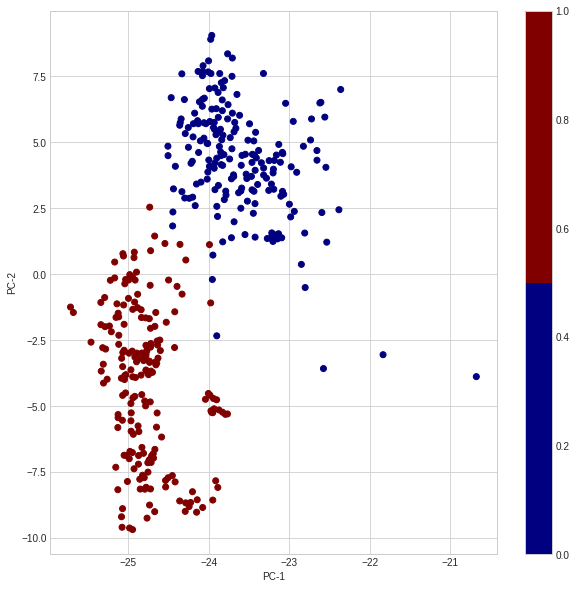

In [ ]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize = (10,10))
c_map = plt.cm.get_cmap('jet', 2)
plt.scatter(data[:, 0], data[:, 1],
            cmap = c_map , c = y)
plt.colorbar()
plt.xlabel('PC-1') , plt.ylabel('PC-2')
plt.show()

In [ ]:
L = []
cols = [ f'F_{i}' for i in range(4704)]
def predict(i):
    img = cv2.imread(f"dataset_preprocessed/unlabeled_preprocessed/{i}.jpg")
    img = img.astype("float32") / 255
    img = img.flatten().reshape(1,-1)
    frame = h2o.H2OFrame(pd.DataFrame(data=img,columns=cols))
    pred = pipe.predict(frame)
    #pred_pca = h2o.as_list(pca.predict(frame)).to_numpy()
    #frame = h2o.H2OFrame(pd.DataFrame(data=pred_pca,columns=["F_0","F_1"]))
    #pred = gbm.predict(frame)

    p = h2o.as_list(pred["predict"],use_pandas=False)[1][0]
    return p

#for i in range(506):  
#    L.append(predict(i))
predict(1)

Parse progress: |█████████████████████████████████████████████████████████| 100%
pca prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


'0'

In [ ]:
values, counts = np.unique(L, return_counts=True)
print(values)
print(counts)

['0' '1']
[404 102]


In [ ]:

data_labeled = labeled_data.copy()
data_unlabeled = unlabeled_data.copy()

while not data_unlabeled.empty:
    model.fit(train_images,train_labels, epochs=10, batch_size=64,
              validation_data=(val_images,val_labels),
              callbacks=[lr_reduction, model_checkpoint],verbose=0)
    
    data_labeled, data_unlabeled = get_new_train_set(data_labeled,data_unlabeled)
# Identify the response and set of predictors
train, test = dataset.split_frame(ratios=[.8], seed=1234)
y = "labels"
x = list(train.columns)  #if x is defined as all columns except the response, then x is not required
x.remove(y)
# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()
# Run AutoML for 30 seconds
aml = h2o.automl.H2OAutoML()
aml.train(x = x, y = y, training_frame = train)
# Print Leaderboard (ranked by xval metrics)
aml.leaderboard
# (Optional) Evaluate performance on a test set
perf = aml.leader.model_performance(test)
perf.auc()

AutoML progress: |██████ (cancelled)


H2OJobCancelled: ignored

In [ ]:
aml.leaderboard

model_id,mean_per_class_error,logloss,rmse,mse,auc,aucpr
XGBoost_1_AutoML_20210205_144732,0.105326,1.4002,0.742976,0.552013,nan,nan
StackedEnsemble_AllModels_AutoML_20210205_144732,0.140689,0.482614,0.387437,0.150107,nan,nan
XGBoost_2_AutoML_20210205_144732,0.337559,1.71612,0.814257,0.663015,nan,nan
